In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', 100)

In [2]:
trainset = pd.read_csv('data/train.csv')
testset = pd.read_csv('data/test.csv')

In [3]:
col = set(trainset.columns) - set(testset.columns)
type(col)

set

In [4]:
data = []

for feature in trainset.columns:
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
        
    if 'bin' in feature or feature == 'target':
        type='binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real'
    else:#if trainset[feature].dtype == int:
        type = 'integer'
        
    preserve = True
    if feature == 'id':
        preserve == False
        
    dtype = trainset[feature].dtype
    
    category = 'none'
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category ='car'
    elif 'calc' in feature:
        category = 'calculated'
        
    feature_dictionary = {
        'varname':feature,
        'use':use,
        'type':type,
        'preserve':preserve,
        'dtype':dtype,
        'category':category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname','use','type','preserve','dtype','category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,True,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [5]:
metadata[(metadata.type=='categorical') & (metadata.preserve)].index

Index(['id', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [6]:
pd.DataFrame({'count':metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


In [7]:
pd.DataFrame({'count':metadata.groupby(['use','type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


<Figure size 432x288 with 0 Axes>

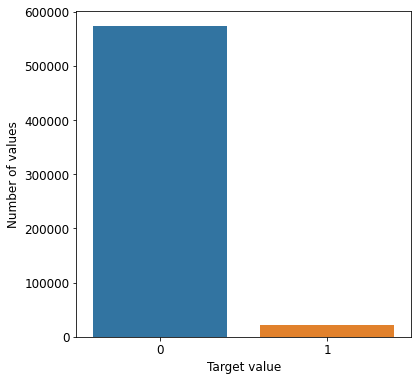

In [8]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset["target"].value_counts().values
    
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [9]:
trainset["target"].value_counts().values[0]/trainset.shape[0]*100, trainset["target"].value_counts().values[1]/trainset.shape[0]*100

(96.3552482140817, 3.6447517859182947)

In [10]:
variable = metadata[(metadata.type=='real')&metadata.preserve].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [11]:
(pow(trainset['ps_car_12']*10,2)).head()

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
Name: ps_car_12, dtype: float64

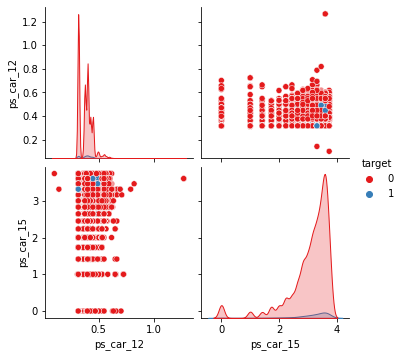

In [12]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12','ps_car_15','target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

In [13]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

<Figure size 432x288 with 0 Axes>

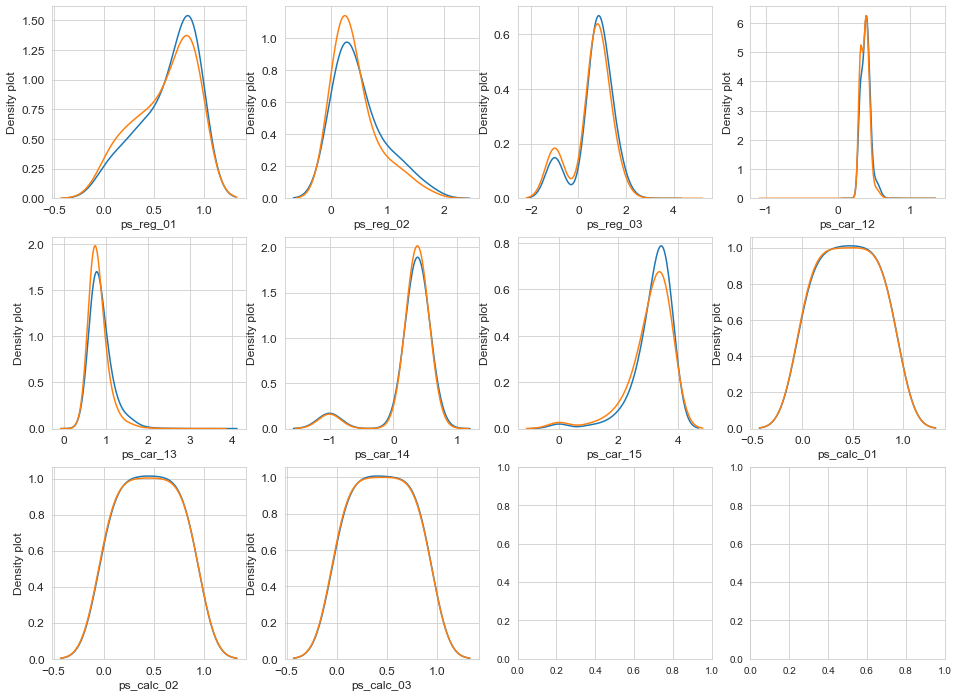

In [14]:
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [15]:
def corr_heatmap(var):
    corrlations = trainset[var].corr()
    
    cmap = sns.diverging_palette(80,1,as_cmap=True)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(corrlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={'shrink':.75})
    plt.show()

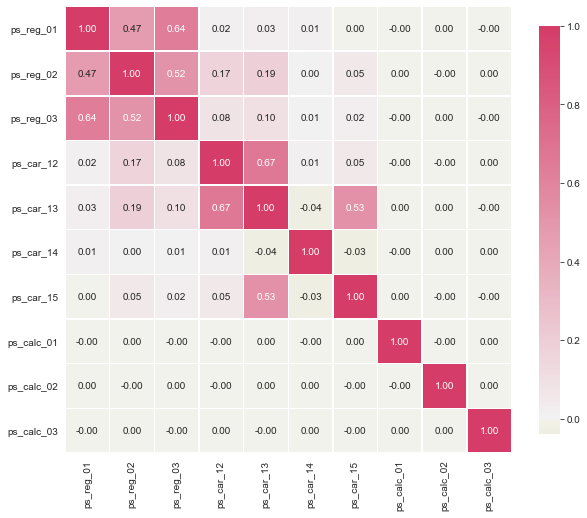

In [16]:
var = metadata[(metadata.type=='real')&(metadata.preserve)].index
corr_heatmap(var)

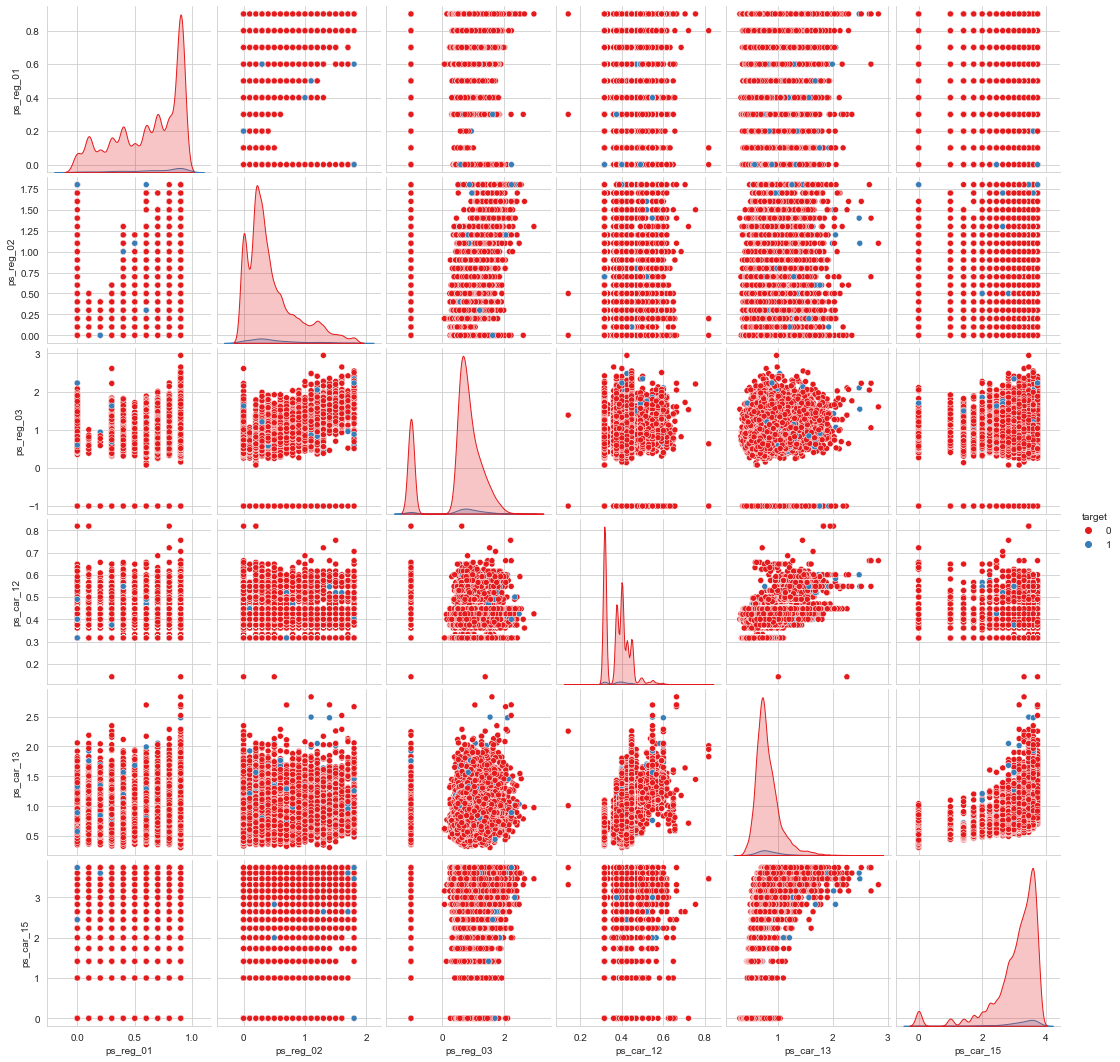

In [17]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

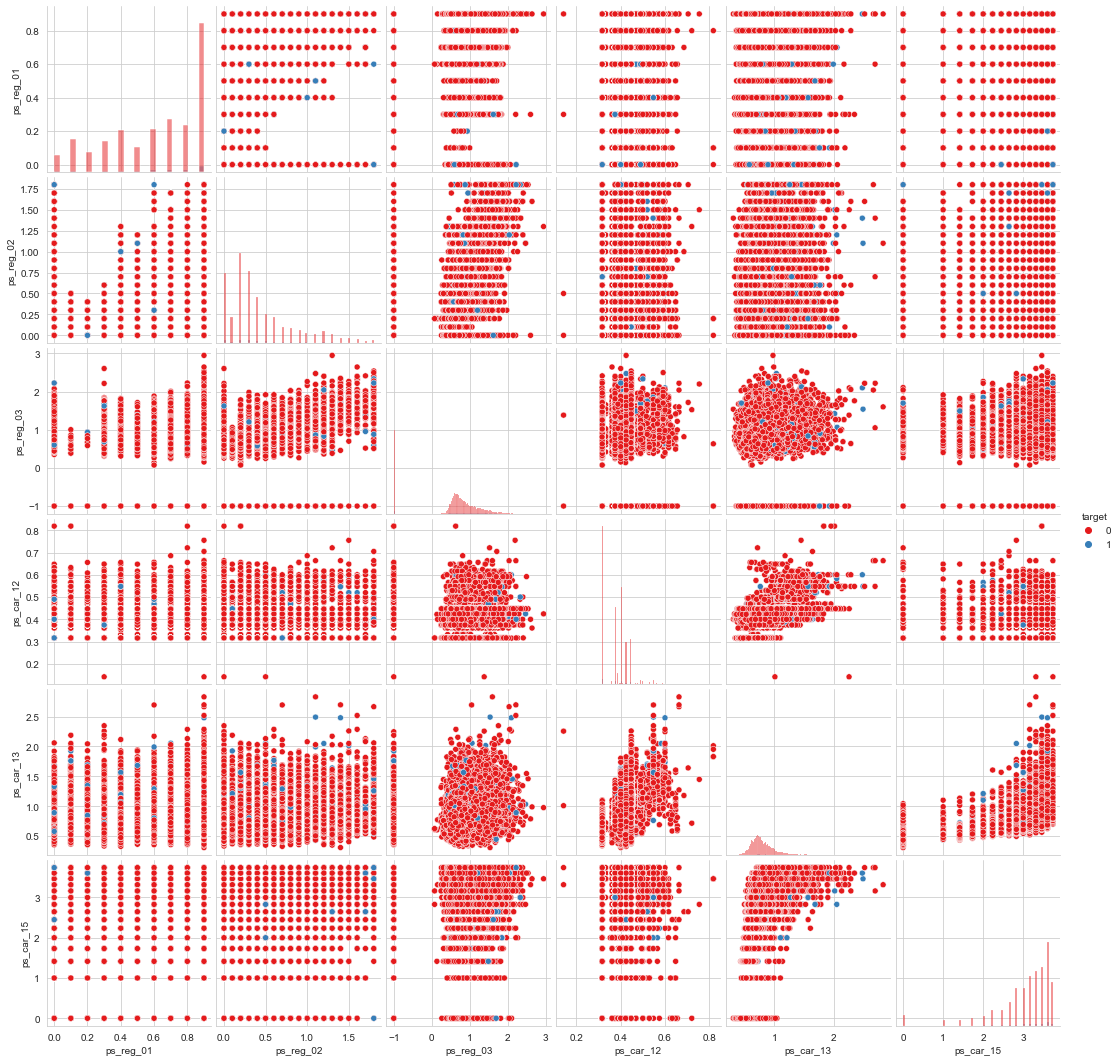

In [18]:
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='hist')

In [19]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Figure size 432x288 with 0 Axes>

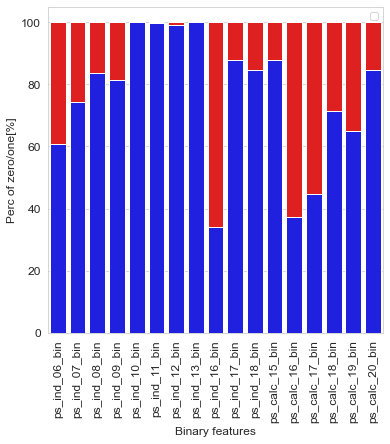

In [20]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100)
    one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100)
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))

p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color='blue')
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom=zero_list, color='red')
plt.ylabel('Perc of zero/one[%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1,p2), ('Zero','One'))
plt.show()

In [21]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)  
testset = testset.drop(col_to_drop, axis=1)  

In [22]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop),'keep'] = False  # Updating the meta

In [23]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [24]:
train_encoded, test_encoded = target_encode(trainset["ps_car_11_cat"], 
                             testset["ps_car_11_cat"], 
                             target=trainset.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat','keep'] = False  # Updating the metadata
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

In [25]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# Get original number of records per target value
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [26]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

In [27]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset,temp],axis=1)
    trainset = trainset.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset,temp],axis=1)
    testset = testset.drop([column],axis=1)

In [28]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target','id'], axis = 1)
testset = testset.drop(['id'], axis = 1)

In [30]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

In [31]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

In [32]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)
       
lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

In [33]:
stack = Ensemble(n_splits=3,
        stacker = log_model,
        base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))  

In [34]:
y_prediction = stack.fit_predict(trainset, target_train, testset)     

Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63713 [gini]: 0.27426
Base model 1: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63940 [gini]: 0.27881
Base model 1: fit LGBMClassifier model | fold 3


KeyboardInterrupt: 